# Object detection for EdegeTPU : object detection for Reachy tictactoe 2021

This notebook allow you to use your own training network (with Tensorflow 1) for TPU. 

### Installation when it's the first utilisation : 

#### Installation of pycoral : 

In [ ]:
! cd ~/ && git clone --recurse-submodules https://github.com/google-coral/pycoral

#### Installation of tflite_runtime : 

In [ ]:
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! sudo apt-get update
! sudo apt-get install python3-tflite-runtime

### Utilisation of the training network : 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib notebook 
import cv2 as cv
from PIL import Image 
from PIL import ImageDraw

import time

from pycoral.adapters import classify, common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter

from tflite_runtime.interpreter import Interpreter
from tflite_runtime.interpreter import load_delegate

from reachy_sdk import ReachySDK

from reachy_sdk.trajectory import goto
from reachy_sdk.trajectory.interpolation import InterpolationMode


In [2]:
reachy = ReachySDK('localhost')

Fonction qui permet de dessiner les boxes sur les images : 

In [3]:
def draw_objects(draw, objs, labels):
#Draws the bounding box and label for each object.
  for obj in objs:
    bbox = obj.bbox
    draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                   outline='red')
    draw.text((bbox.xmin + 10, bbox.ymin + 10),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill='red')


In [10]:
path_model = '/home/reachy/dev/reachy-tictactoe/reachy_tictactoe/models/tflite39927/output_tflite_graph_edgetpu.tflite'
path_label = '/home/reachy/dev/reachy-tictactoe/reachy_tictactoe/models/tflite39927/label.txt'

## Test image 

Pour tester la détection des cube, cylindres et cases vides ont peut lancer un code sur une image : 

<IPython.core.display.Javascript object>


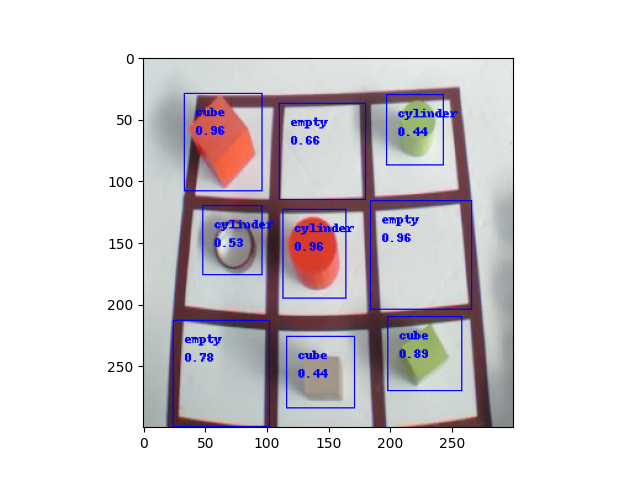

In [8]:
path_model = '/home/reachy/dev/reachy-tictactoe/reachy_tictactoe/models/tflite39927/output_tflite_graph_edgetpu.tflite'
path_label = '/home/reachy/dev/reachy-tictactoe/reachy_tictactoe/models/tflite39927/label.txt'

labels = read_label_file(path_label) if path_label else {}
interpreter = make_interpreter(path_model)
interpreter.allocate_tensors()

reachy.turn_on('head')
reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  
time.sleep(1.5)
reachy.head.look_at(x=1, y=0, z=-0.55, duration=1) 
time.sleep(1.5)

image = reachy.right_camera.wait_for_new_frame()
y1 = 370
y2 = 650
x1 = 30
x2 = 380
dim = (300,300)

image = image[y1:y2, x1:x2]
image = cv.resize(image, dim)
image = Image.fromarray(image)

_, scale = common.set_resized_input(interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

args_threshold = 0.4

interpreter.invoke()
objs = detect.get_objects(interpreter, args_threshold, scale)

#print('-------RESULTS--------')
#if not objs:
    #print('No objects detected')

#for obj in objs:
    #obj = objs[0]
    #print(labels.get(obj.id, obj.id))
    #print('  id:    ', obj.id)
    #print('  score: ', obj.score)
    #print('  bbox:  ', obj.bbox)
draw_objects(ImageDraw.Draw(image), objs, labels)
plt.figure()
plt.imshow(cv.cvtColor(np.asarray(image), cv.COLOR_BGR2RGB))


reachy.head.look_at(x=1.5, y=0, z=0, duration=1.5) 
time.sleep(1.5)
reachy.turn_off_smoothly('reachy')


## Test vidéo 

Pour tester la detection de facons plus intéractive on peut lancer la détection sur une vidéo est bouger les pions pendant que le programme tourne : 

In [11]:
targetSize = (300,300)
fourcc = cv.VideoWriter_fourcc(*'MP4V')
video = cv.VideoWriter('objectDetection_video' + '.mp4', fourcc, 20, targetSize)  
    
reachy.turn_on('head')
reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  
time.sleep(3)
reachy.head.look_at(x=0.8, y=0, z=-0.6, duration=1) 

labels = read_label_file(path_label) if path_label else {}
interpreter = make_interpreter(path_model)
interpreter.allocate_tensors()

start = time.time()
fps_count = 0
nb = 1
while time.time() - start < 15:
    
    image = reachy.right_camera.wait_for_new_frame()
    image = Image.fromarray(image)
    top = 270
    left = 40
    height = 320
    width = 320

    box=(left, top, left+width, top+height)

    image = image.crop(box) 
    image = image.resize(targetSize, Image.ANTIALIAS)
    _, scale = common.set_resized_input(interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

    args_threshold = 0.4


    #start = time.perf_counter()
    interpreter.invoke()
    #inference_time = time.perf_counter() - start
    objs = detect.get_objects(interpreter, args_threshold, scale)

    #print('-------RESULTS--------')
    #if not objs:
        #print('No objects detected')

    #for obj in objs:
        #obj = objs[0]
        #print(labels.get(obj.id, obj.id))
        #print('  id:    ', obj.id)
        #print('  score: ', obj.score)
        #print('  bbox:  ', obj.bbox)
    draw_objects(ImageDraw.Draw(image), objs, labels)
    video.write(np.asarray(image))        
            
video.release()

reachy.head.look_at(0.5, 0, 0, duration=1)
time.sleep(0.2)